<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/am_hierarchial_topic_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective: To perform topic clustering on JPMorgan and UBS bank's Question & Answer data set.

Context: Based on the question and answer text of both the bank, Micro topis, Macro topics which are contextual to G-SIB assessment criteria, Risk of the topic posses and High level topics like asset or liability determined.

In this notebook, The Topic Clustering will be performed.

Approcah:

1. Dendrogram to visulaize possible topic clustering in the data
2. Quarter-Year wise heat map to check topic concentration
3. BERTopic based on 5 parameters. These are High level topic, Macro topic, Risk, Analyst and Micro Topic.
4. Intertopic distant map to visualize the micro topics on a hyper-plane combining all the above parameters.

# Section 1: Install Packages & Libraries

In [ ]:
!pip install -q bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
import umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Section 2: Load dataframe

In [ ]:
# Load your dataset
final_df = pd.read_csv("/content/tqc_topic_cluster.csv")

# Section 3: Dendrogram

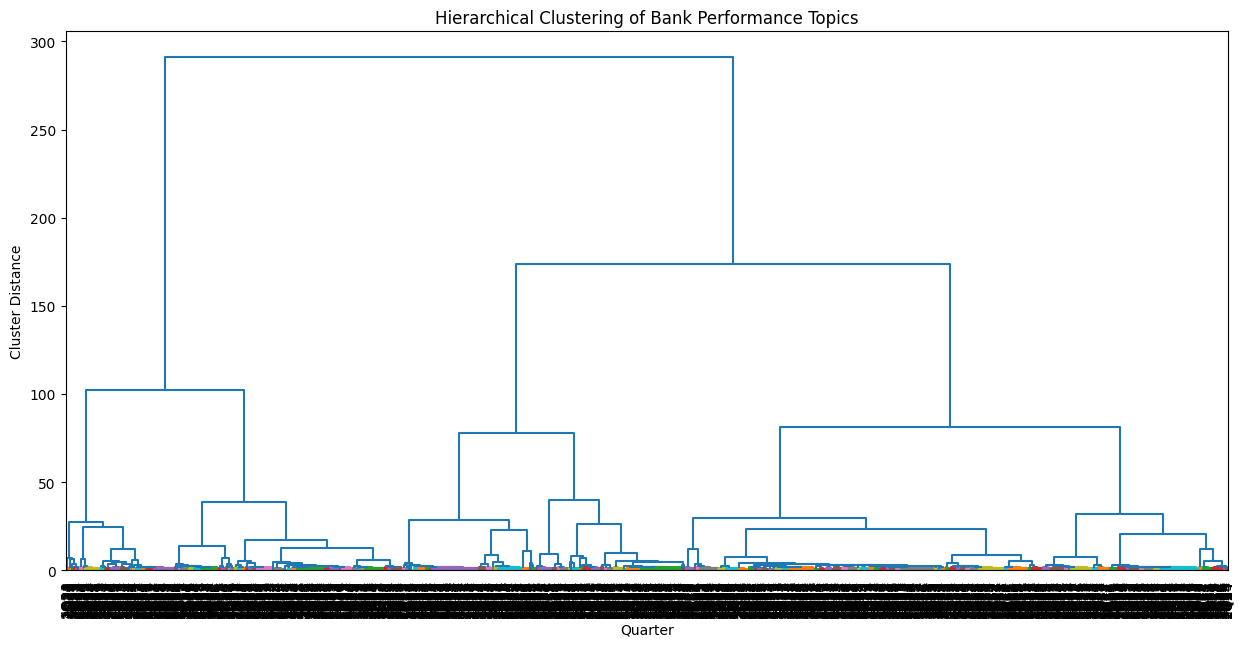

In [ ]:
# Encode categorical variables (Macro Topic, High Level Topic, Topic)
label_enc = LabelEncoder()
final_df["Macro_Topic_Enc"] = label_enc.fit_transform(final_df["Macro Topic"])
final_df["High_Level_Topic_Enc"] = label_enc.fit_transform(final_df["High Level Topic"])

# TF-IDF for 'Topic' column (micro-level topic embedding)
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(final_df["Topic"]).toarray()

# Combine features for clustering
feature_matrix = np.column_stack((final_df["Macro_Topic_Enc"],
                                  final_df["High_Level_Topic_Enc"],
                                  topic_vectors))

# Perform Hierarchical Clustering
linkage_matrix = linkage(feature_matrix, method='ward')

# Set figure size for visualization
plt.figure(figsize=(15, 7))

# Create color labels by 'Quarter' to distinguish groups in dendrogram
quarter_labels = final_df["Quarter"].astype("category").cat.codes  # Numeric encoding for color mapping

# Dendrogram visualization
dendrogram(linkage_matrix, labels=final_df["Quarter"].values,
           leaf_rotation=90, leaf_font_size=10,
           color_threshold=1.5*np.median(linkage_matrix[:, 2]))  # Adjust threshold for readability

plt.title("Hierarchical Clustering of Bank Performance Topics")
plt.xlabel("Quarter")
plt.ylabel("Cluster Distance")
plt.show()

Two Major Clusters at the Top:

There are two primary branches that merge at a very high cluster distance.
This suggests that bank performance topics fall into two broad categories.
Smaller Subclusters:

Within each of the major branches, we see multiple smaller clusters merging at lower distances.
This means that within each broad category, there are related groups of topics that are more closely related.

# Section 4: Clustering with Heat map

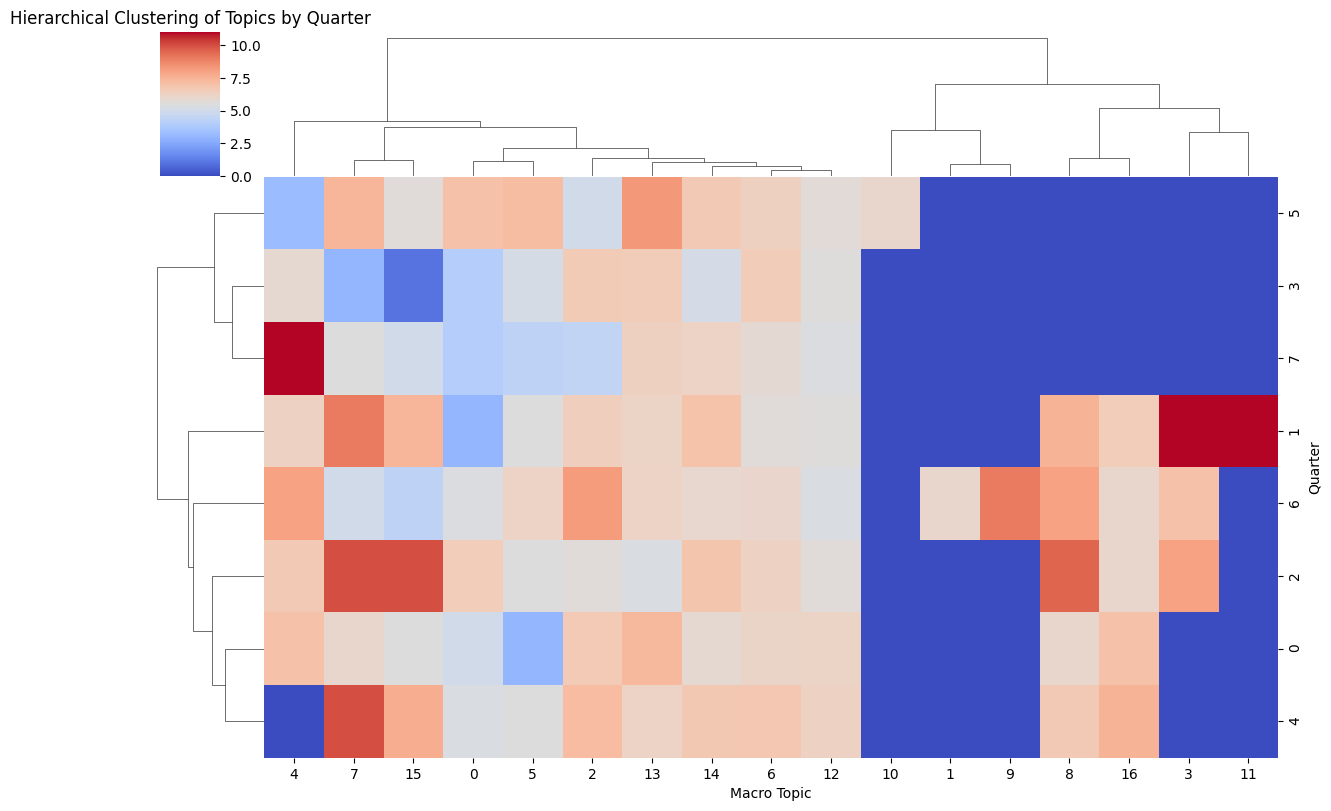

In [ ]:
# Encode categorical variables to numeric
label_encoders = {}
for col in ['Macro Topic', 'High Level Topic', 'Topic', 'Quarter']:
    le = LabelEncoder()
    final_df[col] = le.fit_transform(final_df[col])
    label_encoders[col] = le  # Store encoders for later inverse transform

# Compute distance matrix using categorical encodings
dist_matrix = squareform(pdist(final_df[['Macro Topic', 'High Level Topic', 'Topic']], metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(dist_matrix, method='ward')

# Assign clusters based on Macro Topic hierarchy
final_df['Cluster'] = fcluster(linkage_matrix, t=11, criterion='maxclust')  # 11 unique Macro Topics

# Create a pivot table for visualization
pivot_table = final_df.pivot_table(index='Quarter', columns='Macro Topic', values='Cluster', aggfunc='mean')

# Fill NaN values with 0 before clustering
pivot_table = pivot_table.fillna(0)  # Replace NaN with 0

# Create a clustermap for better visualization
sns.clustermap(pivot_table, method="ward", cmap="coolwarm", figsize=(12, 8), dendrogram_ratio=(0.1, 0.2))
plt.title("Hierarchical Clustering of Topics by Quarter")
plt.show()

Certain Quarters Form Similar Clusters:

The dendrogram on the left groups some quarters closely together.
This suggests that these quarters had similar banking discussions.
For example, Quarters 1 and 6 show similar topic distributions.
Macro Topics Also Cluster Together:

Some macro topics appear closely related (top dendrogram).
These topics may have been frequently discussed together.

# Section 5: Topic CLustering by BERTopic

In [ ]:
# Combine columns to create meaningful topic representations
# Ensure all columns are of string type before concatenation to avoid type errors
final_df["full_text"] = final_df["Macro Topic"].astype(str) + " " + final_df["High Level Topic"].astype(str) + " " + final_df["Topic"].astype(str)

# Step 1: Define UMAP and HDBSCAN parameters
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 2: Create BERTopic Model
topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=True)

# Step 3: Fit the model on the combined textual column
topics, probs = topic_model.fit_transform(final_df["full_text"].values)

# Add topic assignments to DataFrame
final_df["Assigned_Topic"] = topics

# Step 4: Generate Topic Information
topic_info = topic_model.get_topic_info()

2025-03-08 18:14:56,526 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

2025-03-08 18:15:14,926 - BERTopic - Embedding - Completed ✓
2025-03-08 18:15:14,927 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-08 18:15:30,635 - BERTopic - Dimensionality - Completed ✓
2025-03-08 18:15:30,637 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-08 18:15:30,719 - BERTopic - Cluster - Completed ✓
2025-03-08 18:15:30,727 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-08 18:15:30,824 - BERTopic - Representation - Completed ✓


In [ ]:
# Step 5: Visualization - Topic Frequency Bar Chart
topic_model.visualize_barchart(top_n_topics=15)

Business explanation

If applied to G-SIB analysis:

Topics related to risk (e.g., Topic 4 & 10) may represent critical issues affecting banks' systemic importance.
Clustered words indicate specific areas of financial discussion, such as liquidity, capital, or credit risk.
If applied to sentiment analysis:

Topics with more distinct word scores may have stronger positive or negative sentiment trends.
Mapping these to snippet_sent (from your dataset) would help in tracking market sentiment per topic.

In [ ]:
# Step 6: Visualization - 2D UMAP Projection of Topics
fig = topic_model.visualize_topics()  # Returns a Plotly figure

# Display the interactive plot correctly
fig.show()


In [ ]:
# Step 7: Display topic descriptions
topic_model.get_topic_info().head(10)  # Show top 10 topics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,276,-1_15_18_162_16,"[15, 18, 162, 16, 13, 343, 890, 262, 1456, 590]","[6 18 262, 12 3 162, 6 9 162]"
1,0,51,0_82_874_873_848,"[82, 874, 873, 848, 862, 828, 845, 898, 847, 891]","[12 6 82, 12 6 82, 12 6 82]"
2,1,39,1_957_955_954_940,"[957, 955, 954, 940, 943, 938, 93, 928, 923, 921]","[12 18 955, 12 19 957, 12 19 957]"
3,2,36,2_15_1000_428_426,"[15, 1000, 428, 426, 439, 418, 395, 369, 315, ...","[15 3 453, 15 9 369, 15 9 395]"
4,3,28,3_639_659_654_694,"[639, 659, 654, 694, 693, 687, 679, 676, 675, ...","[12 16 639, 12 16 639, 12 16 639]"
5,4,27,4_987_972_941_944,"[987, 972, 941, 944, 982, 978, 977, 976, 975, ...","[14 9 987, 14 6 987, 15 15 987]"
6,5,26,5_709_639_703_75,"[709, 639, 703, 75, 735, 734, 725, 724, 719, 716]","[12 20 639, 12 6 709, 12 20 709]"
7,6,25,6_425_292_333_328,"[425, 292, 333, 328, 327, 325, 319, 310, 309, ...","[13 7 213, 13 20 327, 13 18 257]"
8,7,20,7_1285_1283_1290_1286,"[1285, 1283, 1290, 1286, 1284, 167, 1282, 1281...","[12 20 1016, 12 20 1285, 12 20 1285]"
9,8,20,8_1166_1189_1187_1186,"[1166, 1189, 1187, 1186, 1185, 1184, 1183, 118...","[12 16 1127, 12 18 116, 12 18 1160]"


Summary of Hierarchical Clustering and BERTopic Analysis

1. Dendrogram Insights: Macro-Level Topic Clustering
The hierarchical dendrogram provides a structured view of how bank performance topics cluster over time. The two primary branches at the highest level indicate that macro topics can be grouped into two broad categories, likely reflecting fundamental differences in financial discussions, such as asset growth vs. risk exposure or profitability vs. liquidity concerns. The subclusters within each primary branch suggest that certain topics are more closely related, which means banks tend to discuss particular financial metrics together. The dense clustering at the bottom of the dendrogram indicates that many topics share similar discussion patterns, particularly within specific quarters.

Furthermore, the overlapping x-axis labels indicate that many unique quarters were analyzed, making it difficult to interpret at a glance.

By analyzing the cluster distances, we can infer that some macro topics exhibit high correlation over time, meaning banks consistently focus on them, while others emerge sporadically.

2. Heatmap Observations: Topic Distribution Over Time
The hierarchical heatmap offers a granular view of how macro topics evolved across quarters, showing which topics dominated certain periods and which remained stable over time. Red/orange clusters indicate high prevalence of a topic in a specific quarter, while blue regions suggest low engagement. The strong color differentiation in certain quarters, such as Quarters 1 and 6, suggests that financial events in these periods led to concentrated discussions around specific macro topics. The large blue region on the right indicates that some macro topics were not actively discussed in specific quarters, possibly due to external financial stability.

Another key observation is the presence of isolated red hotspots, which indicate that certain topics gained extreme focus in a few quarters but were largely absent in others. This could signify event-driven banking crises, regulatory interventions, or shifts in investor sentiment. Understanding which macro topics drive these shifts can help in assessing systemic risk in globally important banks.

3. BERTopic Analysis: Topic Differentiation and Sentiment Implications
The BERTopic model effectively extracts and differentiates financial topics, grouping them based on semantic similarity while assigning word importance scores to each cluster. The distinctiveness of certain topics, such as Topics 4 and 10, suggests that some banking themes are highly focused, while others are broader and more evenly distributed across discussions. The fact that some topics have highly weighted key terms indicates that they may correspond to specific financial concerns, such as risk, liquidity, or profitability.
The clustering of certain topics, such as Topics 3, 7, and 10, suggests a natural connection between related financial concepts. These topics could form sub-clusters of broader macro topics (e.g., profitability, credit risk, or capital reserves).
By integrating BERTopic with the hierarchical clustering and heatmap analysis, a more comprehensive financial risk assessment is performed. The intertopic distance map would provide additional insights by showing how close or distant each topic is, indicating whether they are overlapping (similar) or isolated (distinct). When coupled with sentiment analysis, these topics can be classified as positive, neutral, or negative, offering predictive insights into potential banking crises or regulatory shifts.

Final Thoughts
By combining the dendrogram (hierarchical structure), heatmap (temporal topic shifts), and BERTopic (semantic clustering of topics), we gain a holistic view of banking performance discussions over time. The integration of these methods helps in identifying recurring financial risks, detecting seasonality in banking discussions, and predicting systemic financial concerns before they escalate. Future enhancements could include applying sentiment scoring to these clusters and forecasting future topic trends using time-series models.